In [1]:
import numpy as np
from ggplot import *
from pylab import *
from cross_validation import cv
from mpl_toolkits.mplot3d import Axes3D
from numpy import dot
%matplotlib inline
from __future__ import print_function


import six.moves.cPickle as pickle
import gzip
import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T

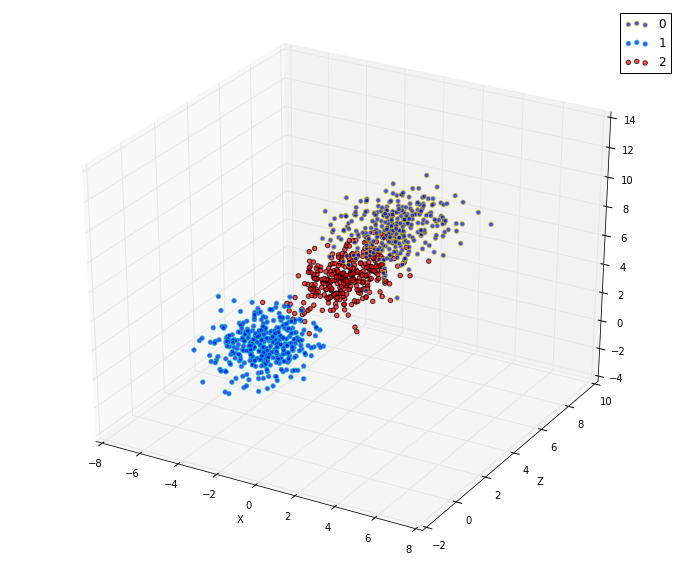

In [2]:
np.random.seed(1234)

cov1 = [[1, .5, 0], [0, 1, 0], [0, 0, 1]]
cov2 = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
cov3 = [[1, 0, 1], [0, 1, 0], [0, 0, 1]]

mean1 = [3, 3, 10]
mean2 = [-3, 2, 1]
mean3 = [-1, 5, 4]

Y = np.random.randint(0, 3, 1000)

X1 = np.random.multivariate_normal(mean1, cov1, 313)
X2 = np.random.multivariate_normal(mean2, cov2, 355)
X3 = np.random.multivariate_normal(mean3, cov3, 332)

X = np.zeros((1000,3))



X[Y == 0] = X1
X[Y == 1] = X2
X[Y == 2] = X3

fig = plt.figure()
fig.set_size_inches(12, 10)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X1[:,0],X1[:,1], X1[:,2], color='y', alpha = 0.7, label="0")
ax.scatter(X2[:,0],X2[:,1], X2[:,2], color='c', alpha = 0.7, label="1")
ax.scatter(X3[:,0],X3[:,1], X3[:,2], c="r", alpha = 0.7, label="2")

xlabel("X")
ylabel("Y")
ylabel("Z")

grid()
legend()

In [3]:
class LogisticRegression(object):
    """Multi-class Logistic Regression Class

    The logistic regression is fully described by a weight matrix :math:`W`
    and bias vector :math:`b`. Classification is done by projecting data
    points onto a set of hyperplanes, the distance to which is used to
    determine a class membership probability.
    """

    def __init__(self, input, n_in, n_out):
        """ Initialize the parameters of the logistic regression

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
                      architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
                     which the datapoints lie

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
                      which the labels lie

        """
        self.W = theano.shared(
            value=numpy.zeros(
                (n_in, n_out),
                dtype=theano.config.floatX
            ),
            name='W',
            borrow=True
        )
        self.b = theano.shared(
            value=numpy.zeros(
                (n_out,),
                dtype=theano.config.floatX
            ),
            name='b',
            borrow=True
        )


        self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)


        self.y_pred = T.argmax(self.p_y_given_x, axis=1)

        self.params = [self.W, self.b]

        self.input = input

    def negative_log_likelihood(self, y):
       
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
     

    def errors(self, y):

        if y.ndim != self.y_pred.ndim:
            raise TypeError(
                'y should have the same shape as self.y_pred',
                ('y', y.type, 'y_pred', self.y_pred.type)
            )
        if y.dtype.startswith('int'):
            return T.mean(T.neq(self.y_pred, y))
        else:
            raise NotImplementedError()            

def load_data(X, Y):

    def shared_dataset(data_x, data_y, borrow=True):

        data_x = data_x
        data_y = data_y
        shared_x = theano.shared(numpy.asarray(data_x,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        shared_y = theano.shared(numpy.asarray(data_y,
                                               dtype=theano.config.floatX),
                                 borrow=borrow)
        return shared_x, T.cast(shared_y, 'int32')

    train_len = int(.6 * len(X))
    test_len = int(len(X) - train_len) / 2
    valid_len = int(len(X) - train_len) / 2

    test_set_x, test_set_y = shared_dataset(X[:train_len], Y[:train_len])
    valid_set_x, valid_set_y = shared_dataset(X[train_len: train_len + test_len],
                                              Y[train_len: train_len + test_len])
    train_set_x, train_set_y = shared_dataset(X[train_len + test_len: train_len + 2*test_len],
                                              Y[train_len + test_len: train_len + 2*test_len])

    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y),
            (test_set_x, test_set_y)]           

    return rval

def sgd(X, Y, learning_rate=0.13, n_epochs=1000, batch_size=600):
    
    datasets = load_data(X,Y)
    
    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] // batch_size
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0] // batch_size
    n_test_batches = test_set_x.get_value(borrow=True).shape[0] // batch_size

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch

    # generate symbolic variables for input (x and y represent a
    # minibatch)
    x = T.matrix('x')  # data, presented as rasterized images
    y = T.ivector('y')  # labels, presented as 1D vector of [int] labels
    classifier = LogisticRegression(x, 3, 3)
    # the cost we minimize during training is the negative log likelihood of
    # the model in symbolic format
    cost = classifier.negative_log_likelihood(y)

    # compiling a Theano function that computes the mistakes that are made by
    # the model on a minibatch
    test_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: test_set_x[index * batch_size: (index + 1) * batch_size],
            y: test_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    # compute the gradient of cost with respect to theta = (W,b)
    g_W = T.grad(cost=cost, wrt=classifier.W)
    g_b = T.grad(cost=cost, wrt=classifier.b)
    
    # start-snippet-3
    # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs.
    updates = [(classifier.W, classifier.W - learning_rate * g_W),
               (classifier.b, classifier.b - learning_rate * g_b)]

    # compiling a Theano function `train_model` that returns the cost, but in
    # the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model = theano.function(
        inputs=[index],
        outpputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    # end-snippet-3

    ###############
    # TRAIN MODEL #
    ###############
    print('... training the model')
    # early-stopping parameters
    patience = 5000  # look as this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is
                                  # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                  # considered significant
    validation_frequency = min(n_train_batches, patience // 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    test_score = 0.
    start_time = timeit.default_timer()

    done_looping = False
    epoch = 0
    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            minibatch_avg_cost = train_model(minibatch_index)
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)

                print(
                    'epoch %i, minibatch %i/%i, validation error %f %%' %
                    (
                        epoch,
                        minibatch_index + 1,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if this_validation_loss < best_validation_loss *  \
                       improvement_threshold:
                        patience = max(patience, iter * patience_increase)

                    best_validation_loss = this_validation_loss
                    # test it on the test set

                    test_losses = [test_model(i)
                                   for i in range(n_test_batches)]
                    test_score = numpy.mean(test_losses)

                    print(
                        (
                            '     epoch %i, minibatch %i/%i, test error of'
                            ' best model %f %%'
                        ) %
                        (
                            epoch,
                            minibatch_index + 1,
                            n_train_batches,
                            test_score * 100.
                        )
                    )

                    # save the best model
                    with open('best_model.pkl', 'wb') as f:
                        pickle.dump(classifier, f)

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print(
        (
            'Optimization complete with best validation score of %f %%,'
            'with test performance %f %%'
        )
        % (best_validation_loss * 100., test_score * 100.)
    )
    print('The code run for %d epochs, with %f epochs/sec' % (
        epoch, 1. * epoch / (end_time - start_time)))
    print(('The code for file ' +
           ' ran for %.1fs' % ((end_time - start_time))), file=sys.stderr)

In [4]:
sgd(X, Y,  learning_rate=0.05, n_epochs=200, batch_size=20)

... building the model
... training the model
epoch 1, minibatch 10/10, validation error 14.500000 %
     epoch 1, minibatch 10/10, test error of best model 10.666667 %
epoch 2, minibatch 10/10, validation error 8.500000 %
     epoch 2, minibatch 10/10, test error of best model 4.333333 %
epoch 3, minibatch 10/10, validation error 5.000000 %
     epoch 3, minibatch 10/10, test error of best model 3.333333 %
epoch 4, minibatch 10/10, validation error 4.000000 %
     epoch 4, minibatch 10/10, test error of best model 3.000000 %
epoch 5, minibatch 10/10, validation error 4.000000 %
epoch 6, minibatch 10/10, validation error 4.000000 %
epoch 7, minibatch 10/10, validation error 4.000000 %
epoch 8, minibatch 10/10, validation error 4.000000 %
epoch 9, minibatch 10/10, validation error 3.500000 %
     epoch 9, minibatch 10/10, test error of best model 2.500000 %
epoch 10, minibatch 10/10, validation error 3.500000 %
epoch 11, minibatch 10/10, validation error 3.000000 %
     epoch 11, miniba

/home/mfc/.virtualenvs/DNN/lib/python3.4/site-packages/IPython/kernel/__main__.py:149: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mfc/.virtualenvs/DNN/lib/python3.4/site-packages/IPython/kernel/__main__.py:150: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mfc/.virtualenvs/DNN/lib/python3.4/site-packages/IPython/kernel/__main__.py:151: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mfc/.virtualenvs/DNN/lib/python3.4/site-packages/IPython/kernel/__main__.py:152: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
The code for file  ran for 0.3s


epoch 176, minibatch 10/10, validation error 1.500000 %
epoch 177, minibatch 10/10, validation error 1.500000 %
epoch 178, minibatch 10/10, validation error 1.500000 %
epoch 179, minibatch 10/10, validation error 1.500000 %
epoch 180, minibatch 10/10, validation error 1.500000 %
epoch 181, minibatch 10/10, validation error 1.500000 %
epoch 182, minibatch 10/10, validation error 1.500000 %
epoch 183, minibatch 10/10, validation error 1.500000 %
epoch 184, minibatch 10/10, validation error 1.500000 %
epoch 185, minibatch 10/10, validation error 1.500000 %
epoch 186, minibatch 10/10, validation error 1.500000 %
epoch 187, minibatch 10/10, validation error 1.500000 %
epoch 188, minibatch 10/10, validation error 1.500000 %
epoch 189, minibatch 10/10, validation error 1.500000 %
epoch 190, minibatch 10/10, validation error 1.500000 %
epoch 191, minibatch 10/10, validation error 1.500000 %
epoch 192, minibatch 10/10, validation error 1.500000 %
epoch 193, minibatch 10/10, validation error 1.

In [5]:
def predict():
    """
    An example of how to load a trained model and use it
    to predict labels.
    """

    # load the saved model
    classifier = pickle.load(open('best_model.pkl'))

    # compile a predictor function
    predict_model = theano.function(
        inputs=[classifier.input],
        outputs=classifier.y_pred)

    # We can test it on some examples from test test
    dataset='mnist.pkl.gz'
    datasets = load_data(dataset)
    test_set_x, test_set_y = datasets[2]
    test_set_x = test_set_x.get_value()

    predicted_values = predict_model(test_set_x[:10])
    print("Predicted values for the first 10 examples in test set:")
    print(predicted_values)